# Kaggle Dataset - Telecom Churn Prediction

It contains information on customers of a telecommunication company and whether they left the company or not. In this project, we will see which types of customers are most likely to leave the company using classification.

## Import packages and data

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.graph_objects as pgo
import plotly.express as px

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# Import data
df = pd.read_csv('telecom_churn.csv')

## Data Exploration

In [3]:
df.head()

,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
0,0,128,1,1,2.7,1,265.1,110,89.0,9.87,10.0
1,0,107,1,1,3.7,1,161.6,123,82.0,9.78,13.7
2,0,137,1,0,0.0,0,243.4,114,52.0,6.06,12.2
3,0,84,0,0,0.0,2,299.4,71,57.0,3.10,6.6
4,0,75,0,0,0.0,3,166.7,113,41.0,7.42,10.1


In [4]:
df.shape

(3333, 11)



The following table contains all variables with their description, data-type and the number of missing values. 

In [4]:
var = {'Description': ['1 if customer cancelled service, 0 if not', 'number of weeks customer has had active account', '1 if customer recently renewed contract, 0 if not', '1 if customer has data plan, 0 if not', 'gigabytes of monthly data usage', 'number of calls into customer service', 'average daytime minutes per month', 'average number of daytime calls', 'average monthly bill', 'largest overage fee in last 12 months', 'average number of roaming minutes'],
       'Datatype': list(df.dtypes),
       '# of NaNs': list(df.isna().sum())}

df_var = pd.DataFrame(var, columns = ['Description', 'Datatype', '# of NaNs'], index = list(df.columns))
df_var

,Description,Datatype,# of NaNs
Churn,"1 if customer cancelled service, 0 if not",int64,0
AccountWeeks,number of weeks customer has had active account,int64,0
ContractRenewal,"1 if customer recently renewed contract, 0 if not",int64,0
DataPlan,"1 if customer has data plan, 0 if not",int64,0
DataUsage,gigabytes of monthly data usage,float64,0
CustServCalls,number of calls into customer service,int64,0
DayMins,average daytime minutes per month,float64,0
DayCalls,average number of daytime calls,int64,0
MonthlyCharge,average monthly bill,float64,0
OverageFee,largest overage fee in last 12 months,float64,0


# Exploratory Data Analysis

Now we will see what insights and relationships can be discovered through analysing the variables. We will start with our target feature 'Churn'. 

## Target variable: 'Churn'

**How high is the proprotion of customers which cancelled the service?**

As described in the table above, this variable is '1' if the customer cancelled the service and '0' if not. 

In [6]:
# Create new dataframe for better labeling of plots
df['churn'] = np.where(df['Churn'] == 1, 'cancelled', 'not cancelled')
df['contract renewal'] = np.where(df['ContractRenewal'] == 1, 'renewed', 'not renewed')
df['data plan'] = np.where(df['DataPlan'] == 1, 'data plan', 'no data plan')

# Create pie chart
labels = ['cancelled', 'not cancelled']
values = [(df.Churn == 1).sum(), (df.Churn == 0).sum()]
fig = pgo.Figure(data = [pgo.Pie(labels = labels, values = values, hole = .6, marker_colors = ['coral',                                                                                                                       
                                                                                               'cornflowerblue'])])
fig.show()

## Binary Features: 'ContractRenewal' and 'DataPlan'

The feature 'ContractRenewal' tells us wether the customer recently renewed his contract (1) or not (0). The feature 'DataPlan' is 1 if the customer had a data plan and 0 else.

We will see how many customers renewed their contract and how many had a data plan in this dataset. Additionaly we will use 'Churn' as a third variable in our plots to hopefully gain first insights of who is more likely to leave the company.

(array([0, 1]), [Text(0, 0, 'not renewed'), Text(1, 0, 'renewed')])

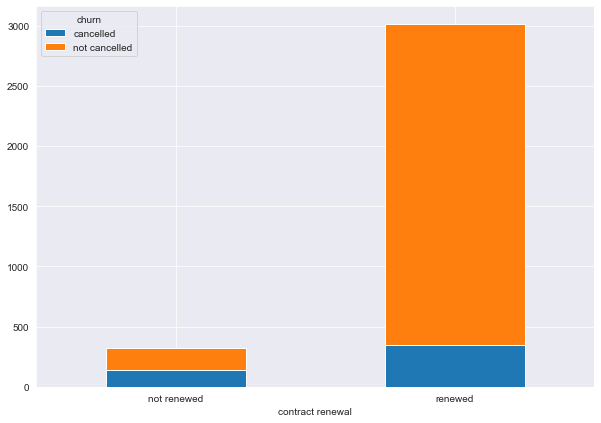

In [7]:
# Create barchart for 'ContractRenewal'
sns.set_style("darkgrid")
df_plot = df.groupby(['churn', 'contract renewal']).size().reset_index().pivot(columns = 'churn', index = 'contract renewal', values = 0)
df_plot.plot(kind = 'bar', stacked = True, figsize = (10, 7))
plt.xticks(rotation = 0)

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

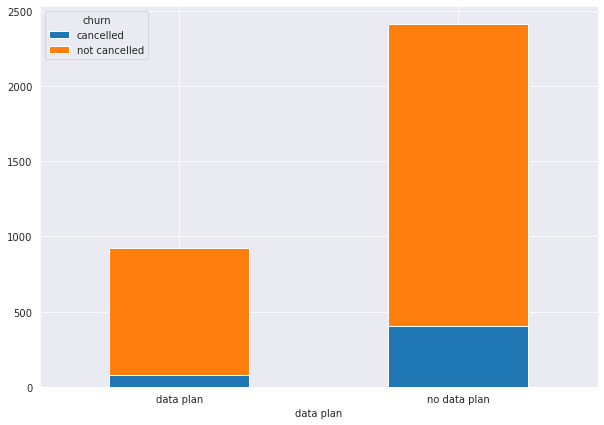

In [7]:
# Create barchart for 'DataPlan'
df_plot = df.groupby(['churn', 'data plan']).size().reset_index().pivot(columns = 'churn', index = 'data plan', values = 0)
df_plot.plot(kind = 'bar', stacked = True, figsize = (10, 7))
plt.xticks(rotation = 0)

* Only around 27% of customers have a data plan in this dataset.
* There is no significant difference in the proportion of cancelled contracts in these two groups.
* In the group with no data plan around 16% and in the other group 11% left the company.

## Relationship: 'DataUsage' & 'MonthlyCharge' & 'Churn'

<AxesSubplot:xlabel='DataUsage', ylabel='MonthlyCharge'>

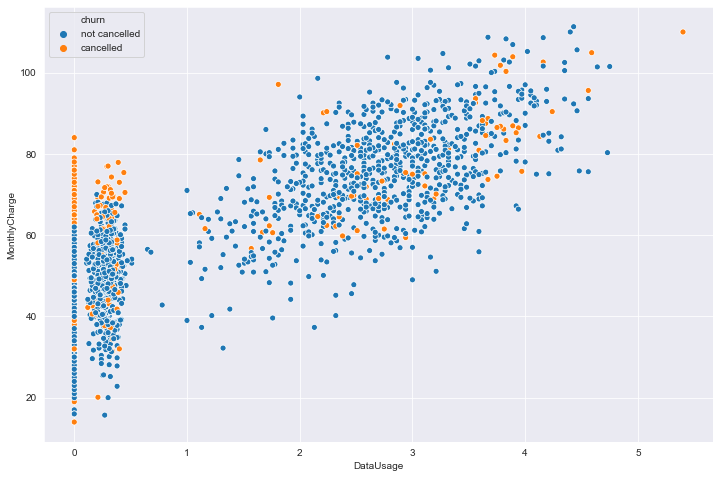

In [18]:
# Create scatterplot
plt.figure(figsize = (12, 8))
sns.scatterplot(data = df, x = 'DataUsage', y = 'MonthlyCharge', hue = 'churn')

As predicted, there is a positive correlation between data usage and monthly charge. What we can also observe is that most customers with low to no data usage but a high monthly charge left the company.

## Relationship: 'Daymins' & 'MonthlyCharge' & 'Churn' 


<AxesSubplot:xlabel='DayMins', ylabel='MonthlyCharge'>

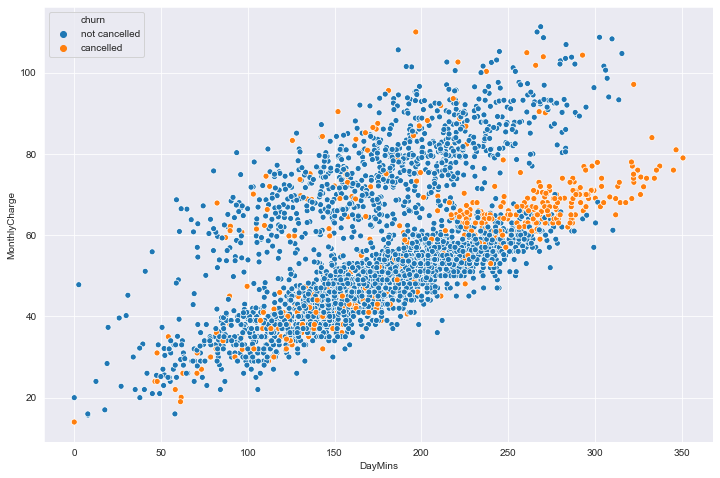

In [20]:
# Create scatterplot
plt.figure(figsize = (12, 8))
sns.scatterplot(data = df, x = 'DayMins', y = 'MonthlyCharge', hue = 'churn')

## Conclusion

After this analysis we now more about relationships of the variables and what kind of customers the company. We will now use Machine-Learning-Models to have a precise classification of the costumers in there leaving-behavior.

# Data Preparation

**Define target variable, features and split the data into train and test**

In [21]:
# Define target and features
y = df['Churn']
X = df.iloc[:, 1:11]

# Stratified train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2666, 10)
(2666,)
(667, 10)
(667,)


**Resampling**

In [22]:
# Merge X_train and y_train
df_train = X_train.merge(y_train.to_frame(), left_index = True, right_index = True)

# Indicies of each class' observations
df_train0 = df_train[df_train['Churn'] == 0]
df_train1 = df_train[df_train['Churn'] == 1]

# Number of observations in each class
n_0 = len(df_train0)
n_1 = len(df_train1)

# Downsampling
df_train0_ds = resample(df_train0, replace = False, n_samples = n_1, random_state = 123)
df_train_ds = pd.concat([df_train0_ds, df_train1])
print("Downsampled Dataset Class Counts:", df_train_ds.Churn.value_counts(), sep = "\n")

# Upsampling
df_train1_us = resample(df_train1, replace = True, n_samples = n_0, random_state = 123)
df_train_us = pd.concat([df_train1_us, df_train0])
print("\nUpsampled Dataset Class Counts:", df_train_us.Churn.value_counts(), sep = "\n")

# Seperate y and X
y_train_ds = df_train_ds['Churn']
X_train_ds = df_train_ds.iloc[:, 0:10]

y_train_us = df_train_us['Churn']
X_train_us = df_train_us.iloc[:, 0:10]

Downsampled Dataset Class Counts:
1    386
0    386
Name: Churn, dtype: int64

Upsampled Dataset Class Counts:
1    2280
0    2280
Name: Churn, dtype: int64


# ML-Models

We will define a function which lets us use and compare multiple models without having to write the code multiple times. As performence metric we will use the normal accuracy score and "Area under the ROC-Curve" as it better represents the performance in a classification problem.

In [34]:
# Set up function which uses an algo as input and returns the accuracy score and AUROC for the input data
def alg_fit(alg, X_train, y_train):
    
    # Model selection
    mod = alg.fit(X_train, y_train)
    
    # Prediction
    y_pred = mod.predict(X_test)
    
    # Accuracy Score
    acc_score = accuracy_score(y_test, y_pred)
    print("Accuracy Score: ", acc_score)
    
    # AUROC
    prob_y = mod.predict_proba(X_test)
    prob_y = [p[1] for p in prob_y]
    auroc_score = roc_auc_score(y_test, prob_y)
    print("AUROC Score:", auroc_score)

In [35]:
# Set up function which uses function alg_fit and returns a comparison of the accuracy score and AUROC for imbalanced, downsampled and upsampled data
def compare_results(alg):
    # Unsampled Dataset
    print("IMBALANCED CLASSES")
    alg_fit(alg, X_train, y_train)

    # Downsampled majority class
    print("\nDOWNSAMPLED MAJORITY CLASS")
    alg_fit(alg, X_train_ds, y_train_ds)

    # Upsampled minority class
    print("\nUPSAMPLED MINORITY CLASS")
    alg_fit(alg, X_train_us, y_train_us)

## Logistic Regression 

Let's have a look at the first model and how it performs on the data with imbalanced classes, downsampled majority class and upsampled minority class.

In [25]:
# Logistic Regression
compare_results(LogisticRegression(max_iter = 1000))

IMBALANCED CLASSES
Accuracy Score:  0.8650674662668666
AUROC Score: 0.8316332067281605

DOWNSAMPLED MAJORITY CLASS
Accuracy Score:  0.7586206896551724
AUROC Score: 0.8280159160788569

UPSAMPLED MINORITY CLASS
Accuracy Score:  0.7646176911544228
AUROC Score: 0.8348887683125339


It is ok that the accuracy metric is lower for the resampled data as it is expected. We will focus more on the AUROC-score as it is a better precision metric for our classification models. Here, upsampling the minority class yields the best result.

## Gaussian Naive Bayes

In [26]:
# Gaussian Naive Bayes
compare_results(GaussianNB())

IMBALANCED CLASSES
Accuracy Score:  0.8500749625187406
AUROC Score: 0.8722915536263338

DOWNSAMPLED MAJORITY CLASS
Accuracy Score:  0.8530734632683659
AUROC Score: 0.8689817326822209

UPSAMPLED MINORITY CLASS
Accuracy Score:  0.8515742128935532
AUROC Score: 0.8682040151926207


Here, the AUROC-score for the resampled data is even lower than with imbalanced classes. But still the precision is higher than for Logistic Regression.

## K-nearest Neighbors 

In [27]:
# K-nearest Neighbors
compare_results(KNeighborsClassifier(n_neighbors = 3))

IMBALANCED CLASSES
Accuracy Score:  0.8500749625187406
AUROC Score: 0.6817055525411467

DOWNSAMPLED MAJORITY CLASS
Accuracy Score:  0.5982008995502249
AUROC Score: 0.6437059142702115

UPSAMPLED MINORITY CLASS
Accuracy Score:  0.7406296851574213
AUROC Score: 0.6618918430095859


So the k-nearest neighbor didn't perform that good.

## Decision Tree 

In [28]:
# Decision Tree Classifier
compare_results(DecisionTreeClassifier(random_state = 0, max_depth = 4))

IMBALANCED CLASSES
Accuracy Score:  0.9400299850074962
AUROC Score: 0.9005606800506422

DOWNSAMPLED MAJORITY CLASS
Accuracy Score:  0.8710644677661169
AUROC Score: 0.9047657804304575

UPSAMPLED MINORITY CLASS
Accuracy Score:  0.896551724137931
AUROC Score: 0.9173177789835413


We have a new accuracy high with the decision tree. 

## Random Forest 

In [29]:
# Random Forest Classifier
rfc = RandomForestClassifier(random_state = 0, n_estimators = 50, max_depth = 5)
compare_results(rfc)

IMBALANCED CLASSES
Accuracy Score:  0.9385307346326837
AUROC Score: 0.9336227165852776

DOWNSAMPLED MAJORITY CLASS
Accuracy Score:  0.8845577211394303
AUROC Score: 0.9193344185205282

UPSAMPLED MINORITY CLASS
Accuracy Score:  0.9115442278860569
AUROC Score: 0.9338126243443661


As forseeable Random Forest performed even better than a single decision tree.

## Gradient Boosting 

In [30]:
# Gradient Boosting Classifier
gbc = GradientBoostingClassifier(random_state = 0, n_estimators = 50, max_depth = 3, 
                                 min_samples_leaf = 5)
compare_results(gbc)

IMBALANCED CLASSES
Accuracy Score:  0.9505247376311844
AUROC Score: 0.9269578585639358

DOWNSAMPLED MAJORITY CLASS
Accuracy Score:  0.8740629685157422
AUROC Score: 0.9241273286308553

UPSAMPLED MINORITY CLASS
Accuracy Score:  0.8950524737631185
AUROC Score: 0.928368601917164


Besides the increase in the AUROC-Score with downsampled majority class nothing has increased with Gradient-Boosting.

## XG-Boost 

In [41]:
# XG-Boost Classifier
xgb = XGBClassifier(learning_rate = 0.15,
                    n_estimators = 1000,
                    max_depth = 20,
                    min_child_weight = 1,
                    gamma = 0.5,
                    subsample = 0.8,
                    colsample_bytree = 0.8,
                    reg_alpha = 0.03,
                    objective = 'binary:logistic',
                    nthread = 4,
                    scale_pos_weight = 1,
                    use_label_encoder = False,
                    seed = 27)
compare_results(xgb)

IMBALANCED CLASSES
[20:17:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy Score:  0.9490254872563718
AUROC Score: 0.9193886778802677

DOWNSAMPLED MAJORITY CLASS
[20:17:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy Score:  0.8680659670164917
AUROC Score: 0.9134382347621631

UPSAMPLED MINORITY CLASS
[20:17:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with

The accuracy is higher but the AUROC-score of the Random-Forest Classifier is still the highest.

## Confusion Matrix, Recall and Precision

We will have a look at the confusion matrices of the last three models (Random Forest, Gradient Boosting & XGBoost) as they performed the best. Additionally, we are going to focus on the models with upsampled minority class as for all it yielded the highest AUROC Score.

In [44]:
# List of best algos with parameter tuned
best_algs = [rfc, gbc, xgb]
names = ["RandomForestClassifier", "GradientBoostingClassifier", "XGBoost"]

# Return confusion matrices (absolute), precision and recall
j = 0
for i in best_algs:
    mod = i.fit(X_train_us, y_train_us)
    y_pred = mod.predict(X_test)
    con_mat = confusion_matrix(y_test, y_pred)
    prec = (con_mat[0][0])/(con_mat[0][0] + con_mat[0][1])
    rec = (con_mat[0][0])/(con_mat[0][0] + con_mat[1][0])
    f1_score = 2*prec*rec/(prec+rec)
    print("\n", names[j], "Confusion Matrix:\n", con_mat, "\nPrecision: ", prec, "\nRecall: ", rec, "\nF1-Score: ", f1_score)
    j = j + 1


 RandomForestClassifier Confusion Matrix:
 [[522  48]
 [ 11  86]] 
Precision:  0.9157894736842105 
Recall:  0.9793621013133208 
F1-Score:  0.9465095194922937

 GradientBoostingClassifier Confusion Matrix:
 [[516  54]
 [ 16  81]] 
Precision:  0.9052631578947369 
Recall:  0.9699248120300752 
F1-Score:  0.9364791288566244
[20:26:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 XGBoost Confusion Matrix:
 [[559  11]
 [ 24  73]] 
Precision:  0.980701754385965 
Recall:  0.9588336192109777 
F1-Score:  0.9696444058976583


## Final Result

Our Random-Forest Model actually had the highest AUROC-Score and Recall. But the Accuracy and Precision of our XG-Boost Classifier outperformed the Random-Forest Model.

## Feature Importance

We will use the XG-Boost Classifier to detect the most important features.

In [39]:
# Feature importance
df_feature_importance = pd.DataFrame(xgb.feature_importances_, index = X_train_us.columns, 
                                     columns = ['feature importance']).sort_values('feature importance', 
                                                                                   ascending = False)
df_feature_importance

,feature importance
ContractRenewal,0.337636
DataPlan,0.161336
CustServCalls,0.125763
DataUsage,0.090486
DayMins,0.077939
MonthlyCharge,0.060132
RoamMins,0.044779
DayCalls,0.041619
AccountWeeks,0.031150
OverageFee,0.029160
